# Develop a predictive maintenance model using LSTM-RNN to forecast equipment failures, enabling proactive maintenance and reducing downtime.

In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential



In [5]:
#choosing DOM_hourly.csv data for analysis
fpath="C://Users//TmC//Downloads//AEP_hourly.csv//AEP_hourly.csv"

df=pd.read_csv(fpath)
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [6]:
#Let's use datetime(2012-10-01 12:00:00,...) as index instead of numbers(0,1,...)
#This will be helpful for further data analysis as we are dealing with time series data
df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [7]:
#checking missing data
df.isna().sum()

AEP_MW    0
dtype: int64

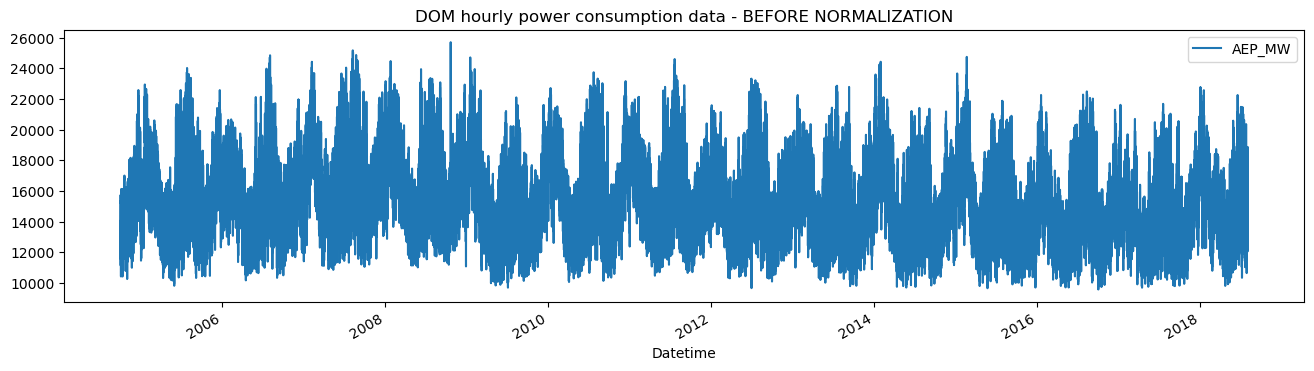

In [8]:
df.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

In [14]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['AEP_MW']=scaler.fit_transform(df['AEP_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape


(121273, 1)

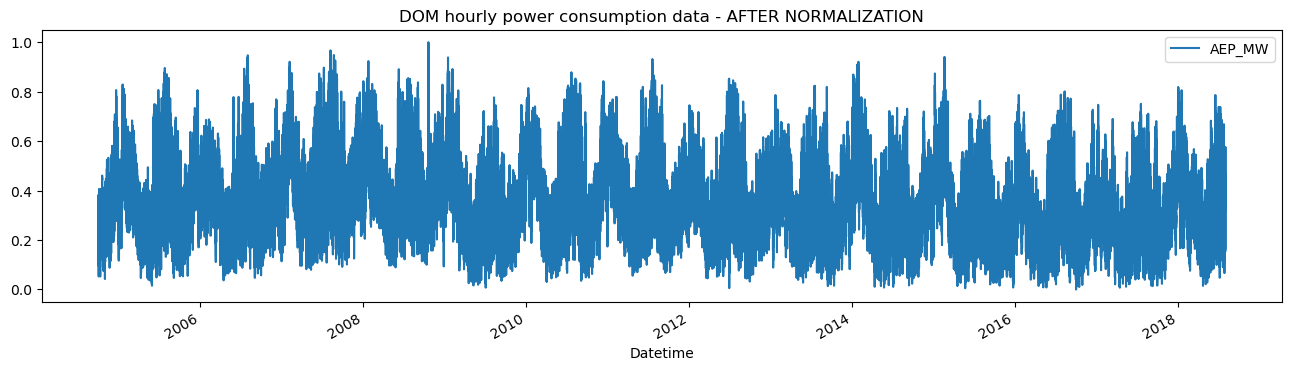

In [15]:
df_norm.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

In [16]:
df_norm.shape

(121273, 1)

# Prepare data for training the RNN models

In [17]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [18]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (11253, 20, 1)
y_test.shape =  (11253,)


# Build a SIMPLE RNN model

In [19]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 dropout (Dropout)           (None, 20, 40)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 40)            3240      
                                                                 
 dropout_1 (Dropout)         (None, 20, 40)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [20]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 9s 63ms/step - loss: 0.0622
Epoch 2/10
110/110 [==============================] - 9s 78ms/step - loss: 0.0141
Epoch 3/10
110/110 [==============================] - 9s 85ms/step - loss: 0.0083
Epoch 4/10
110/110 [==============================] - 8s 74ms/step - loss: 0.0060
Epoch 5/10
110/110 [==============================] - 13s 116ms/step - loss: 0.0047
Epoch 6/10
110/110 [==============================] - 9s 81ms/step - loss: 0.0039
Epoch 7/10
110/110 [==============================] - 8s 76ms/step - loss: 0.0034
Epoch 8/10
110/110 [==============================] - 8s 73ms/step - loss: 0.0030
Epoch 9/10
110/110 [==============================] - 9s 78ms/step - loss: 0.0028
Epoch 10/10
110/110 [==============================] - 9s 78ms/step - loss: 0.0025


In [21]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

352/352 [==============================] - 2s 3ms/step
R2 Score of RNN model =  0.9683723956717427


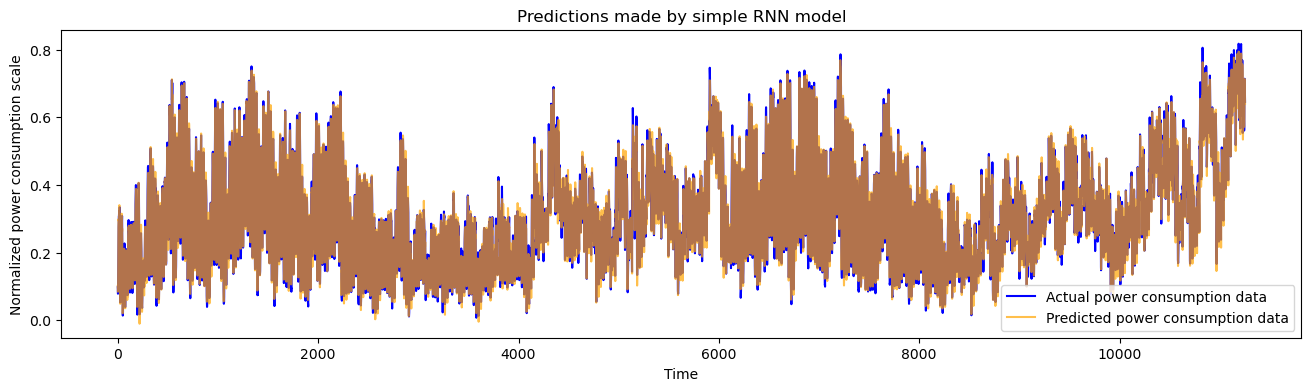

In [22]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

# Build an LSTM model

In [23]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20, 40)            6720      
                                                                 
 dropout_3 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 20, 40)            12960     
                                                                 
 dropout_4 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_3 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [24]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 25s 175ms/step - loss: 0.0246
Epoch 2/10
110/110 [==============================] - 22s 197ms/step - loss: 0.0132
Epoch 3/10
110/110 [==============================] - 21s 186ms/step - loss: 0.0066
Epoch 4/10
110/110 [==============================] - 22s 201ms/step - loss: 0.0042
Epoch 5/10
110/110 [==============================] - 26s 232ms/step - loss: 0.0030
Epoch 6/10
110/110 [==============================] - 18s 166ms/step - loss: 0.0025
Epoch 7/10
110/110 [==============================] - 17s 159ms/step - loss: 0.0022
Epoch 8/10
110/110 [==============================] - 22s 197ms/step - loss: 0.0021
Epoch 9/10
110/110 [==============================] - 19s 176ms/step - loss: 0.0019
Epoch 10/10
110/110 [==============================] - 23s 207ms/step - loss: 0.0018


In [25]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

352/352 [==============================] - 3s 6ms/step
R^2 Score of LSTM model =  0.967351669877305


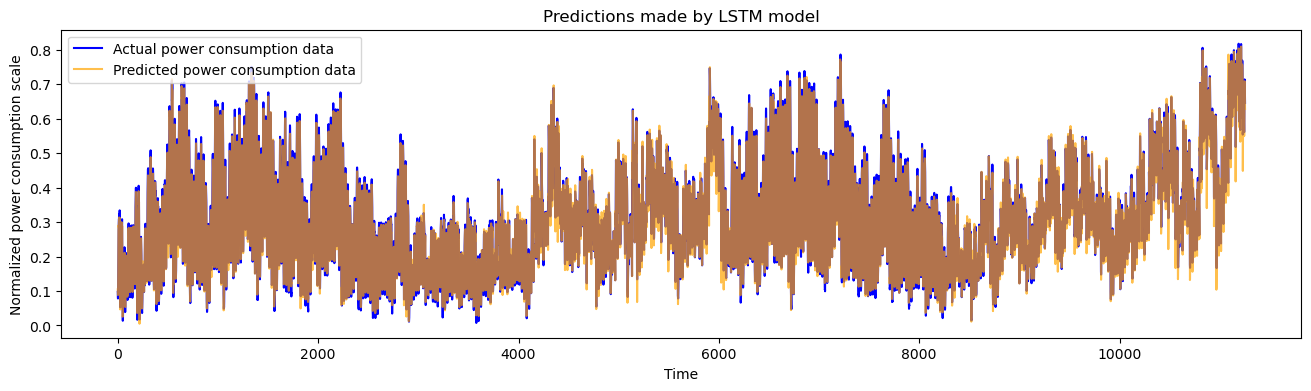

In [26]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

# Compare predictions made by simple RNN, LSTM model by plotting data in a single graph

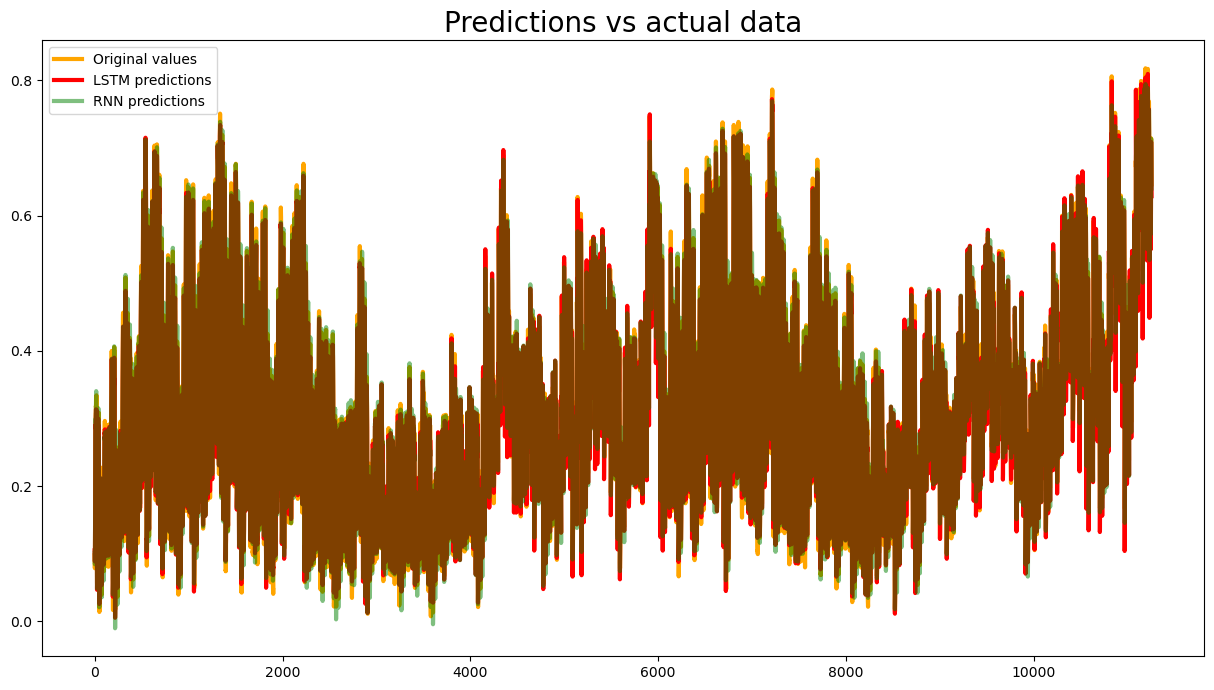

In [27]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()